# Steigung

In [11]:
import pdal 
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import os
import sys
import open3d as o3d
import time 

from interessant import * # Bei Änderungen Kernel neu starten

sys.path.append("/home/riannek/code/gleis/gleisachse")
from algs.voxelfilter import *
from algs.centralpoints import *
import settings as s


In [12]:
steigung 

['steigung1.laz', 'steigung2.laz', 'steigung3.laz', 'steigung4.laz']

In [13]:
grad = 4

promille = 1000 * np.tan(np.deg2rad(grad))
print("Steigung in Promille:", promille)

Steigung in Promille: 69.92681194351042


In [14]:
filename = os.path.join(basedir, "steigung",  'steigung4.laz')
filename = os.path.join(basedir, "steigung",  'quer4.laz')

print(filename)
os.path.exists(filename)

/media/riannek/minimax/gleis/steigung/quer4.laz


True

In [15]:
intensity_threshold = 14500
gauge = 1.435
railhead_width = 0.067

## Voxel Filter

In [17]:
voxel_size = s.tile_size / s.voxelcount

constraints = vf.GeometryConstraints(
    voxel_size, 
    s.voxel_minimum_points, 
    s.voxel_empty_space_thresh, 
    s.voxel_ground_percentile, 
    s.voxel_top_percentile,
    s.voxel_majority_thresh, 
    s.max_rail_above_ground,
    )

In [18]:
points, _ = voxelfilter(
    filename, 
    voxel_size,
    constraints,
    s.cluster_minimum_points,
    "",
    write=False,
    )

if points is None:
    raise ValueError("No rail points found in the file.")

In [19]:
xyz = np.vstack((points['X'], points['Y'], points['Z'])).transpose()

offset = xyz.mean(axis=0).round() 
xyz -= offset

intensity = points['Intensity']
intensity_normalized = (intensity - intensity.min()) / (intensity.max() - intensity.min())
colormap = plt.get_cmap("viridis")
intensity_colors = colormap(intensity_normalized)
intensity_colors = intensity_colors[:, :3]

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)
pcd.colors = o3d.utility.Vector3dVector(intensity_colors)

o3d.visualization.draw_geometries([pcd])

In [20]:
voxel_size 

0.8333333333333334

In [21]:
# Diagonale eines Voxels 
voxel_diagonal = np.sqrt(2) * voxel_size
voxel_diagonal

np.float64(1.1785113019775793)

## Seed Points

In [22]:
low_intensity = points[points["Intensity"] < intensity_threshold]
low_intensity.shape

(37966,)

In [23]:
min_gauge = gauge - 0.025
max_gauge = gauge + 0.025

In [24]:
# Downsample with poisson sampling (only original bbox)

# downsampling_pipeline = pdal.Filter.crop(bounds=bounds).pipeline(low_intensity) | pdal.Filter("filters.sample", radius=downsample_radius)

downsampling_pipeline = pdal.Filter("filters.sample", radius=s.seedpoint_distance).pipeline(low_intensity)
downsampling_pipeline.execute()
seed_points = downsampling_pipeline.arrays[0]
seed_point_count = seed_points.shape[0]
seed_point_count

513

In [25]:
xyz_seed = np.vstack((seed_points['X'], seed_points['Y'], seed_points['Z'])).transpose()
xyz_seed -= offset

## Plot Funktionen

In [26]:
def plot_cluster_pair(cluster, cluster_other, transformmatrix, representive_a, representive_b, railhead_width = 0.067): 
    """
    """
    center = (cluster.sum(axis=0) + cluster_other.sum(axis=0)) / (cluster.shape[0] + cluster_other.shape[0])
    center_cluster = cluster.mean(axis=0)
    center_other = cluster_other.mean(axis=0)


    cluster = cluster - center_cluster
    cluster_other = cluster_other - center_other


    transformed = cluster @ transformmatrix
    transformed_other = cluster_other @ transformmatrix
    
    representive_a = representive_a - center_cluster
    representive_b = representive_b - center_other
    representive_a = representive_a @ transformmatrix
    representive_b = representive_b @ transformmatrix


    # Check if we need to switch the left, right cluster
    center_cluster_in_pc = (center_cluster - center) @ transformmatrix
    center_other_in_pc = (center_other - center) @ transformmatrix
    if center_cluster_in_pc[0] > center_other_in_pc[0]:
        transformed, transformed_other = transformed_other, transformed
        representive_a, representive_b = representive_b, representive_a
        print("Switched clusters")

    fig, ax = plt.subplots(1,2, figsize=(15, 7))

    ax[0].set_ylim(-0.08, 0.08)
    ax[1].set_ylim(-0.08, 0.08)

    ax[0].axvline(0, color="lightgrey", linestyle="-", zorder=-1)
    ax[0].axhline(0, color="lightgrey", linestyle="-", zorder=-1)
    ax[1].axvline(0, color="lightgrey", linestyle="-", zorder=-1)
    ax[1].axhline(0, color="lightgrey", linestyle="-", zorder=-1)

    ax[0].scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax[0].set_aspect("equal")


    ax[0].axvline(representive_a[0], color="steelblue", linestyle="--", zorder=-1)
    ax[0].axvline(representive_a[0] - (railhead_width/2), color="skyblue", linestyle="--", zorder=-1)
    ax[0].axvline(representive_a[0] + (railhead_width/2), color="skyblue", linestyle="--", zorder=-1)
    ax[0].axhline(representive_a[2], color="steelblue", linestyle="--", zorder=-1)

    ax[1].scatter(transformed_other[:,0], transformed_other[:,2], c=transformed_other[:,1], cmap=plt.cm.plasma, marker=".")
    ax[1].set_aspect("equal")

    ax[1].axvline(representive_b[0], color="steelblue", linestyle="--", zorder=-1)
    ax[1].axvline(representive_b[0] - (railhead_width/2), color="skyblue", linestyle="--", zorder=-1)
    ax[1].axvline(representive_b[0] + (railhead_width/2), color="skyblue", linestyle="--", zorder=-1)
    ax[1].axhline(representive_b[2], color="steelblue", linestyle="--", zorder=-1)

    plt.show()
    return fig, ax, transformed, transformed_other

In [27]:
def plot_cluster(cluster, eigenvects=None): 
    center = cluster.mean(axis=0)
    centered = cluster - center

    if eigenvects is None:
        eigenvals, eigenvects = pca(cluster)

    transformed = centered @ eigenvects
    fig, ax = plt.subplots(figsize=(10, 15))
    ax.scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax.set_aspect("equal")
    plt.show()
    return fig, ax

## Als Funktion

In [28]:
def get_points(xyz, xyz_seed):
    points = []
    centralpoints = []
    lines = []
    eigenvectlines = []
    distances = []
    befahren = []
    tree = KDTree(xyz)  

    # indices: ndarray (dtype object) with a list of indices for each seed point
    indices = tree.query_ball_point(xyz_seed, r=s.neighborhood_radius, workers=-1)
    seed_point_count = len(xyz_seed)

    for cluster, clustercenter, cluster_other, center_other, eigenvects in pair_generator(xyz, tree, indices, seed_point_count, gauge, railhead_width):
        transformmatrix = get_transformmatrix(cluster, cluster_other, clustercenter, center_other, eigenvects)
        representative_a, side_a  = representative_point(cluster, transformmatrix, railhead_width) 
        representative_b, side_b = representative_point(cluster_other, transformmatrix, railhead_width)

        if representative_a is None or representative_b is None:
            # Happens in rare cases at switches
            continue
        
        # Check if both are classified as the same side
        # but a zero and non zero value is not a problem
        if side_a * side_b < 0:
            # Update the cluster with lower confidence of the side estimation
            if np.abs(side_a) < np.abs(side_b):
                representative_a, side_a  = representative_point(cluster, transformmatrix, railhead_width, side=side_b)
            else:
                representative_b, side_b = representative_point(cluster_other, transformmatrix,  railhead_width, side=side_a)

        if representative_a is None or representative_b is None:
            # Happens in rare cases at switches
            continue


        central = get_central_point(representative_a, representative_b)
        

        local_gauge = np.linalg.norm(representative_a - representative_b) - railhead_width
        if not (min_gauge < local_gauge < max_gauge):
            # Gauge is too small or too large
            continue

        centralpoints.append(central)
        points.append(representative_a)
        points.append(representative_b)
        lines.append(pv.Line(representative_a, representative_b))
        distances.append(np.linalg.norm(representative_a - representative_b) - railhead_width)
        eigenvectlines.append(
            pv.Line(
                representative_a, 
                representative_a + (eigenvects[:,0] * 0.5), 
            )
        )
        befahren.append(
            int(side_a == 0 and side_b == 0)
        )

    return np.array(points), np.array(centralpoints), np.array(distances), lines, eigenvectlines, np.array(befahren)


In [29]:
start = time.time()
mypoints, centralpoints, distances, lines, eigenvectlines, befahren = get_points(xyz, xyz_seed)
print(time.time() - start, "s")
pv_mypoints = pv.PolyData(mypoints)
pv_centralpoints = pv.PolyData(centralpoints) 
pv_centralpoints['distance'] = distances
pv_centralpoints['befahren'] = befahren


1.9831962585449219 s


## Visualisierung

In [30]:
pv_all = pv.PolyData(xyz)
pv_seed = pv.PolyData(xyz_seed) 
with_lines = True

In [31]:

p = pv.Plotter()

if with_lines:
    # Add lines (SLOW)
    # for color, line in zip(side_distances, lines):
    #     p.add_mesh(line, scalars=color, cmap='plasma')
    for line in lines:
        p.add_mesh(line, color="red")

    # for line in eigenvectlines:
    #     p.add_mesh(line, color="blue", line_width=2)

p.add_mesh(pv_all, color='gray', point_size=2)
p.add_mesh(pv_mypoints, color="green", point_size=4)
p.add_mesh(pv_centralpoints, color="blue", point_size=8, render_points_as_spheres=True)


p.show()


Widget(value='<iframe src="http://localhost:40809/index.html?ui=P_0x7faeaa351160_0&reconnect=auto" class="pyvi…

## Einzeln

In [32]:
tree = KDTree(xyz)  
indices = tree.query_ball_point(xyz_seed, r=s.neighborhood_radius, workers=-1)
seed_point_count = len(xyz_seed)

pair_gen = pair_generator(xyz, tree, indices, seed_point_count, gauge, railhead_width)

In [33]:
for i in range(30):
    next(pair_gen)

Sides -0.3284671532846715 -0.26126126126126126
Points per Cluster 411 405
Switched clusters


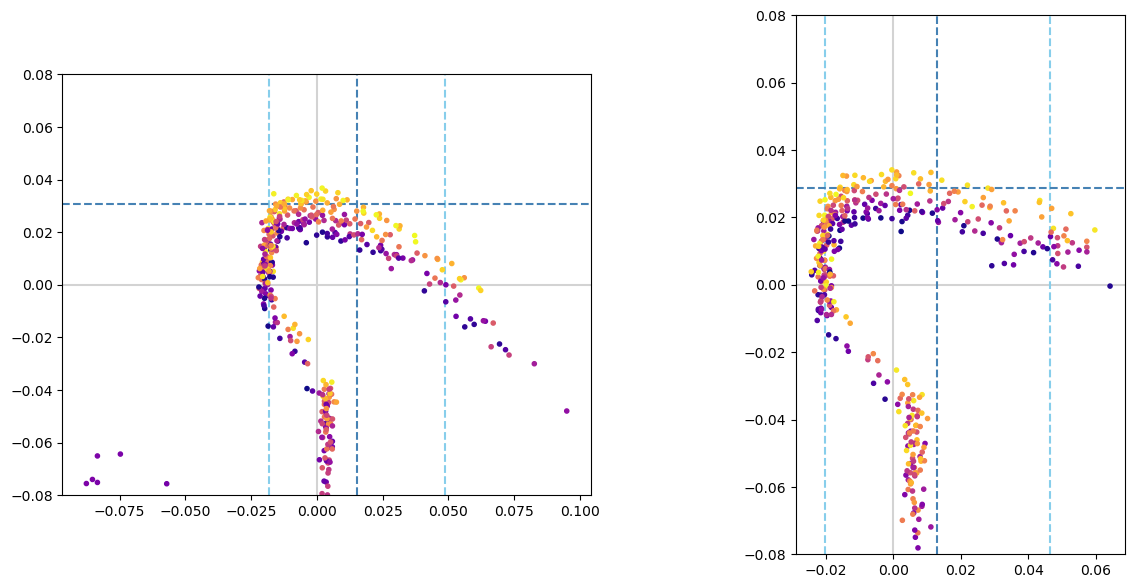

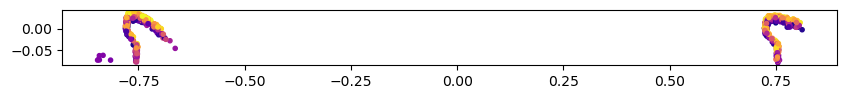

In [34]:
cluster, clustercenter, cluster_other, clustercenter_other, eigenvects = next(pair_gen)

transformmatrix = get_transformmatrix(cluster, cluster_other, clustercenter, clustercenter_other, eigenvects)


representative_a, side_a  = representative_point(cluster, transformmatrix)
representative_b, side_b = representative_point(cluster_other, transformmatrix)

print("Sides", side_a, side_b)

# Check if both are classified as the same side
# but a zero and non zero value is not a problem
if side_a * side_b < 0:
    print("Different sides")
    # Update the cluster with lower confidence of the side estimation
    if np.abs(side_a) < np.abs(side_b):
        representative_aaa, side_a  = representative_point(cluster, transformmatrix)
    else:
        representative_bbb, side_b = representative_point(cluster_other, transformmatrix,side=side_a)



central = get_central_point(representative_a, representative_b)

print("Points per Cluster", len(cluster), len(cluster_other))
fig, ax, transformed, transformed_other = plot_cluster_pair(cluster, cluster_other, transformmatrix, representative_a, representative_b, railhead_width = 0.067)

pair = np.vstack((cluster, cluster_other))
plot_cluster(pair, transformmatrix);


In [35]:
pcd_clusters = o3d.geometry.PointCloud()
pcd_clusters.points = o3d.utility.Vector3dVector(pair)
pcd_clusters.paint_uniform_color([0, 0, 1])

pcd_clustercenters = o3d.geometry.PointCloud()
pcd_clustercenters.points = o3d.utility.Vector3dVector([clustercenter, clustercenter_other])
pcd_clustercenters.paint_uniform_color([0, 1, 0])

pcd_all = o3d.geometry.PointCloud()
pcd_all.points = o3d.utility.Vector3dVector(xyz)
pcd_all.paint_uniform_color([0.7, 0.7, 0.7])

pcd_representative = o3d.geometry.PointCloud()
pcd_representative.points = o3d.utility.Vector3dVector([representative_a, representative_b, central])
pcd_representative.paint_uniform_color([1, 0, 0])

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])

o3d.visualization.draw_geometries([pcd_all, pcd_clusters, mesh_frame, pcd_clustercenters, pcd_representative])

# Experimentieren